# Explore feature combinations from a database

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayoshi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.

Previously, we have selected features which can add the most information  
to the analysis. Now, we want to find ways to mixture the features to obtain  
possible correlations among our data.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
# from astroquery.simbad import Simbad
# from astroquery.ned import Ned
from scipy.cluster import hierarchy as hc
from scipy.spatial import distance
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import getpass
import progressbar
import pandas as pd
import re
import missingno as msno
import itertools

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [6]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [7]:
cmap           = cm.get_cmap('inferno')
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [8]:
pe1            = [mpe.Stroke(linewidth=3, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

---

## Reading data

In [9]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

We separate our data in luminosities and redshift values (column name `z_value`).

It is important to keep in mind that columns with luminosity values start their names with `Luminosity...`  
and they are in `W / Hz`.  

Uncertainties have not been included up to this point. They are included (as flux uncertainties in the file `large_cat_simbad_inayoshi_ned.h5`).

In [10]:
large_catalog_df = pd.read_hdf(cat_path + 'large_cat_lums_z_clean_jun2020.h5', 'df').drop(columns=['z_val', 'origin'])
redshift_df      = pd.read_hdf(cat_path + 'large_cat_lums_z_clean_jun2020.h5', 'df')['z_val']
origin_df        = pd.read_hdf(cat_path + 'large_cat_lums_z_clean_jun2020.h5', 'df')['origin']  # 0:SDSS+FIRST, 1:COSMOS, 2:RADIO, 3:Inayoshi

Data could be also converted into `astropy` Tables.

In [11]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

It is possible to save column names into a plain text file to keep track of them.

In [12]:
# np.savetxt(cat_path + 'column_names_lums.txt', large_catalog_df.columns, fmt='%s', delimiter='\n')

Missing values have been replaced with the number $-99.0$ which, in the context of our dataset,  
is a very unlikely quantity to be found.

If needed (not for the moment) these values can be masked and treated as proper missing values.

In [13]:
large_catalog_df[large_catalog_df == -99.0] = None

---

In [14]:
large_catalog_df.columns

Index(['Luminosity K', 'Luminosity H', 'Luminosity J', 'Luminosity Y',
       'Luminosity I', 'Luminosity r', 'Luminosity V', 'Luminosity g',
       'Luminosity B', 'Luminosity u', 'Luminosity NUV', 'Luminosity FUV',
       'Luminosity 10-968 MHz', 'Luminosity 1.4-1.7 GHz',
       'Luminosity 2.2-5.5 GHz', 'Luminosity 7.7-163.1 GHz',
       'Luminosity 203-375 GHz', 'Luminosity 150-500 microns',
       'Luminosity 10-100 microns', 'Luminosity 3-8 microns',
       'Luminosity 0.1-195 keV', 'Luminosity 0.1-100 GeV'],
      dtype='object')

---

We can explore, individually, the quotients between pairs of features (luminosities).

In [15]:
col_a         = 'Luminosity 1.4-1.7 GHz'
col_b         = 'Luminosity 0.1-195 keV'
quot          = large_catalog_df[col_a] / large_catalog_df[col_b]
filter_finite = np.isfinite(quot)

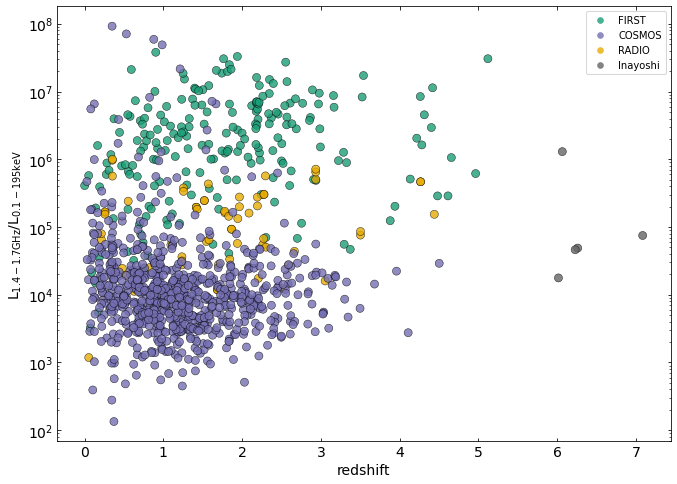

In [16]:
fig          = plt.figure(figsize=(11,8))
ax1          = fig.add_subplot(111)

# ax1.plot(redshift_df, quot, color=colors[0], alpha=0.75, marker='.', ls='')
scatter_out  = ax1.scatter(redshift_df[filter_finite], quot[filter_finite], c=origin_df[filter_finite],\
                           alpha=0.80, marker='o', s=65, cmap='Dark2', edgecolor='k', linewidths=0.5)

col_a_label  = '\mathrm{L}_{\mathrm{' + col_a.replace('Luminosity ', '') + '}}'
col_b_label  = '\mathrm{L}_{\mathrm{' + col_b.replace('Luminosity ', '') + '}}'

axis_label   = f'${col_a_label} / {col_b_label}$'

#ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_xlabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_xlabel('redshift', size=14)
# ax1.set_ylabel('quotient', size=14)
ax1.set_ylabel(axis_label, size=14)
ax1.tick_params(which='both',top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)

# produce a legend with the unique colors from the scatter
classes = ['FIRST', 'COSMOS', 'RADIO', 'Inayoshi']
plt.legend(handles=scatter_out.legend_elements()[0], labels=classes)